In [1]:
import sys
sys.path.insert(0, '../')
from model.cpm_limb import CPMHandLimb

import argparse
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import matplotlib
import cv2
import json

cuda = torch.cuda.is_available()
device_id = [0]
torch.cuda.set_device(device_id[0])

In [2]:
def projectPoints(xyz, K):
    """ Project 3D coordinates provided by the hands dataset into image space. """
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    return uv[:, :2] / uv[:, -1:]

def read_json_data(file_path):
    with open(file_path) as file:
        content = json.load(file)
    return content

def load_image(img_path):
    ori_im = Image.open(img_path)
    ori_w, ori_h = ori_im.size
    im = ori_im.resize((368, 368))
    image = transforms.ToTensor()(im)
    image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])(image)  # (C,H,W)
    image = image.unsqueeze(0)  # (1,C,H,W)
    return ori_im, image, ori_w, ori_h


def get_image_coordinate(pred_map, ori_w, ori_h):
    """
    decode heatmap of one image to coordinates
    :param pred_map: Tensor  CPU     size:(1, 21, 46, 46)
    :return:
    label_list: Type:list, Length:21,  element: [x,y]
    """
    pred_map = pred_map.squeeze(0)
    label_list = []
    for k in range(21):
        tmp_pre = np.asarray(pred_map[k, :, :])  # 2D array  size:(46,46)
        corr = np.where(tmp_pre == np.max(tmp_pre))  # coordinate of keypoints in 46 * 46 scale

        # get coordinate of keypoints in origin image scale
        x = int(corr[1][0] * (int(ori_w) / 46.0))
        y = int(corr[0][0] * (int(ori_h) / 46.0))
        label_list.append([x, y])
    return label_list

def draw_point(points, im):
    i = 0
    draw = ImageDraw.Draw(im)

    for point in points:
        x = point[0]
        y = point[1]

        if i == 0:
            rootx = x
            rooty = y
        if i == 1 or i == 5 or i == 9 or i == 13 or i == 17:
            prex = rootx
            prey = rooty

        if i > 0 and i <= 4:
            draw.line((prex, prey, x, y), 'red')
            draw.ellipse((x - 3, y - 3, x + 3, y + 3), 'red', 'white')
        if i > 4 and i <= 8:
            draw.line((prex, prey, x, y), 'yellow')
            draw.ellipse((x - 3, y - 3, x + 3, y + 3), 'yellow', 'white')

        if i > 8 and i <= 12:
            draw.line((prex, prey, x, y), 'green')
            draw.ellipse((x - 3, y - 3, x + 3, y + 3), 'green', 'white')
        if i > 12 and i <= 16:
            draw.line((prex, prey, x, y), 'blue')
            draw.ellipse((x - 3, y - 3, x + 3, y + 3), 'blue', 'white')
        if i > 16 and i <= 20:
            draw.line((prex, prey, x, y), 'purple')
            draw.ellipse((x - 3, y - 3, x + 3, y + 3), 'purple', 'white')

        prex = x
        prey = y
        i = i + 1
    return im


def annotate_image(points, oriImg):
    edges = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 5], [5, 6], [6, 7], [7, 8], [0, 9], [9, 10], \
             [10, 11], [11, 12], [0, 13], [13, 14], [14, 15], [15, 16], [0, 17], [17, 18], [18, 19], [19, 20]]

    plt.imshow(oriImg[:, :, [2, 1, 0]])

    for i, (x, y) in enumerate(points):
        plt.plot(x, y, 'r.')
        plt.text(x, y, str(i))

    for ie, e in enumerate(edges):
        rgb = matplotlib.colors.hsv_to_rgb([ie / float(len(edges)), 1.0, 1.0])
        x1, y1 = points[e[0]]
        x2, y2 = points[e[1]]
        plt.plot([x1, x2], [y1, y2], color=rgb)
    plt.axis('off')
    plt.show()

def hand_pose_estimation(model, img_path='images/sample.jpg', save_path='images/sample_out_new.jpg'):
    with torch.no_grad():
        ori_im, img, ori_w, ori_h = load_image(img_path)
        if cuda:
            img = img.cuda()  # # Tensor size:(1,3,368,368)
        _, cm_pred = model(img)
        # limb_pred (FloatTensor.cuda) size:(bz,3,C,46,46)
        # cm_pred   (FloatTensor.cuda) size:(bz,3,21,46,46)

        coordinates = get_image_coordinate(cm_pred[:, -1].cpu(), ori_w, ori_h)
        # Type: list,   Length:21,      element:[x,y]
#         ori_im = draw_point(coordinates, ori_im)
#         image = cv2.imread(img_path)  # B,G,R order
#         annotate_image(coordinates, image)
#         print('save output to ', save_path)
#         ori_im.save(save_path)
        return coordinates

In [4]:
# ******************** build model ********************
# Limb Probabilistic Mask G1 & 6
model = CPMHandLimb(outc=21, lshc=7, pretrained=True)
if cuda:
    model = model.cuda()
    model = nn.DataParallel(model, device_id)

state_dict = torch.load('best_model.pth', map_location='cuda:0')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
dataset_dir=r'D:\PuMuxin\FreiHand'
xyz_array = read_json_data(f'{dataset_dir}\\training_xyz.json')
k_array = read_json_data(f'{dataset_dir}\\training_k.json')

In [6]:
test_image = r'D:\PuMuxin\HandDB\original\naked_hands\00000001.jpg' #r'D:\PuMuxin\NSRMhand\images\sample.jpg'#r'D:\PuMuxin\FreiHand\naked_hands\00000023.jpg'
pre_coordinate = hand_pose_estimation(model, img_path=test_image)
print(pre_coordinate)

[[152, 192], [136, 184], [144, 128], [136, 136], [120, 136], [136, 184], [136, 184], [128, 184], [96, 176], [168, 192], [152, 192], [232, 208], [248, 208], [184, 192], [224, 208], [248, 208], [264, 208], [200, 208], [232, 200], [248, 208], [264, 208]]


In [ ]:
annotate_image(actual_coordinate, image)

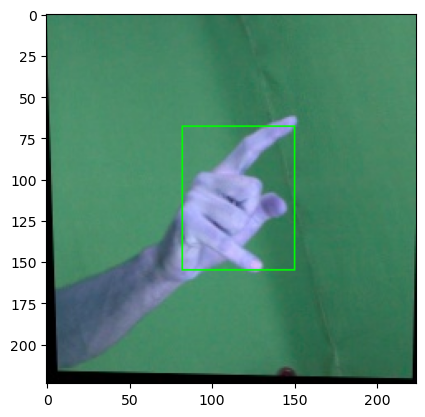

In [90]:
def get_bbox_coordinates(coordinates):
    """
    Get bounding box coordinates for a actual hand landmark.
    """
    all_x, all_y = [], []
    for coordinate in coordinates:
        all_x.append(coordinate[0])
        all_y.append(coordinate[1])
    return min(all_x), min(all_y), max(all_x), max(all_y)

def draw_bbox(coordinates, image):
    x_min, y_min, x_max, y_max = get_bbox_coordinates(coordinates)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)
    plt.imshow(image)
    plt.show()
    
draw_bbox(pre_coordinate, image)

In [91]:
import math

def compute_euclidean_distances(pred_coordinates, actu_coordinates):
    variances = []
    for i in range(len(actu_coordinates)):
        variance = compute_single_euclidean_distances(pred_coordinates[i], actu_coordinates[i])
        variances.append(variance)
    return variances


def compute_single_euclidean_distances(pred_coordinate, actu_coordinate):
    variance = math.sqrt(pow(pred_coordinate[0] - actu_coordinate[0], 2) +
                         pow(pred_coordinate[1] - actu_coordinate[1], 2))
    return variance

def compute_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [92]:
# Compute the area of both the prediction and ground-truth rectangles
predicted_bbox = get_bbox_coordinates(pre_coordinate)
actual_bbox = get_bbox_coordinates(actual_coordinate)
iou = compute_intersection_over_union(predicted_bbox, actual_bbox)
print(iou)

coordinates_variances = compute_euclidean_distances(pre_coordinate, actual_coordinate)
print(len(coordinates_variances))
print(coordinates_variances)

0.8604578726055132
21
[78.89233169326408, 22.135943621178654, 23.345235059857504, 39.11521443121589, 43.08131845707603, 40.45985664828782, 5.385164807134504, 1.4142135623730951, 4.123105625617661, 6.708203932499369, 25.019992006393608, 41.10960958218893, 26.476404589747453, 18.35755975068582, 34.20526275297414, 47.67598976424087, 63.694583757176716, 30.805843601498726, 44.91102314577124, 57.07889277132134, 75.0066663703967]


In [101]:
def tabulate_csv_result(filename, iou, coordinates_variances):
    coordinates_mean_error = sum(coordinates_variances) / len(coordinates_variances)
    data = [filename, iou, coordinates_mean_error]
    for each in coordinates_variances:
        data.append(each)
    return data

csv_result = tabulate_csv_result(test_image, iou, coordinates_variances)
csv_result

['D:\\PuMuxin\\FreiHand\\naked_hands\\00000010.jpg',
 0.8604578726055132,
 34.714400758614296,
 78.89233169326408,
 22.135943621178654,
 23.345235059857504,
 39.11521443121589,
 43.08131845707603,
 40.45985664828782,
 5.385164807134504,
 1.4142135623730951,
 4.123105625617661,
 6.708203932499369,
 25.019992006393608,
 41.10960958218893,
 26.476404589747453,
 18.35755975068582,
 34.20526275297414,
 47.67598976424087,
 63.694583757176716,
 30.805843601498726,
 44.91102314577124,
 57.07889277132134,
 75.0066663703967]

In [112]:
output = ['00000010.jpg', 0.8604578726055132, 34.714400758614296, 78.89233169326408, 22.135943621178654, 23.345235059857504, 39.11521443121589, 43.08131845707603, 40.45985664828782, 5.385164807134504, 1.4142135623730951, 4.123105625617661, 6.708203932499369, 25.019992006393608, 41.10960958218893, 26.476404589747453, 18.35755975068582, 34.20526275297414, 47.67598976424087, 63.694583757176716, 30.805843601498726, 44.91102314577124, 57.07889277132134, 75.0066663703967]
newoutput = ['00000010.jpg',0.8604578726055132,34.714400758614296,78.89233169326408,22.135943621178654,23.345235059857504,39.11521443121589,43.08131845707603,40.45985664828782,5.385164807134504,1.4142135623730951,4.123105625617661,6.708203932499369,25.019992006393608,41.10960958218893,26.476404589747453,18.35755975068582,34.20526275297414,47.67598976424087,63.694583757176716,30.805843601498726,44.91102314577124,57.07889277132134,75.0066663703967]
for i in range(1, len(output)):
    if newoutput[i] != csv_result[i]:
        print(f"{str(i)} has error")
print('ok...')

ok...
